# LASSO Regression
## Do Imports

In [1]:
import os
import pandas
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy
#import mpld3
from matplotlib.backends.backend_pdf import PdfPages
import logging
from scipy import stats
import seaborn
from decimal import Decimal


FORMAT='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(format=FORMAT)
LOG=logging.getLogger()
LOG.setLevel(logging.INFO)
%matplotlib inline

## How to run this notebook
To run the code in this notebook,

    1) install [jupyter notebook](http://jupyter.org/install.html)
    
    2) open command prompt or terminal
    
    3) cd into directory containing this notebook and data
    
    4) run `$jupyter notebook` 
    
    5) open this notebook
    
    6) change `dire` variable (below) to the directory where this document before running the code. 

In [2]:
dire = r'C:\Users\Ciaran\Documents\Miscellaneous\LassoRegression'
## read data
lasso_data_filename = os.path.join(dire, 'DataForLasso.csv')
data = pandas.read_csv(lasso_data_filename,index_col=[0,1])
data = data.transpose()


## convert str column headers to int
columns1 = data.columns.get_level_values(0)
columns2 = data.columns.get_level_values(1)
columns1 = [int(i) for i in columns1]
columns2 = [int(i) for i in columns2]
data.columns = [columns1,columns2]


## get list of genes fro later
genes = list(data.index)

## Lasso Regression
I've isolated the TGFb treatment of the microarray data (BJ fibroblasts: 10ng/mL treatment over 180minutes). The  0 time point in this data was not treated with TGFb and is a `no-treatment` control. The data has 6 repeats, 8 time points (including the 0) and 217 differentially expressed genes (DEGs), as determined by LIMMA package in R. 

In this document I'm testing the LASSO regression technique to see how useful it can be with our data. I'll be using the JunB data as a response variable $Y$ and all other genes in the set of DEGs as predictor variables $X$

A complication with our dataset is that we have time course data. For the analysis in the next cell, I've only considered the 180 minute data. 

### Summary
Data: 6 repeats of TGFb treated microarray data at 180minutes post TGFb stimulation

Dependent variable: JunB

Independent variables: all other genes determined to be differentially expressed by LIMMA

The [LassoCV](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html) class was used to estimated the best value of `alpha` by cross-validation

### Functions
The function called `lasso_for_timepoint` in the next cell performs a lasso regression analysis on the microarray DEG data at a single time point. The function `lasso_for_gene` iterates over time and uses the `lasso_for_timepoint` for each time point. 

### Overview of Algorithm

Let: 
    
    G = Number of Genes
    R = Number of Repeats
    T = Number of Time points
    
    y = Response Variable. All repeats of Gene g at time t. R x 1 vector: 
                        
                        i.e if JunB == response variable                                 
                                R  180min
                                1   -
                                2   -
                                .   .
                                6   -
    
    X = Predictor variables. All repeats of all genes != y at time t. RxG matrix
    
                        i.e. at t = 180min
                            R    Gene_1    Gene_2    ...    Gene_n
                            1       -         -      ...       -
                            2       .                          . 
                            3       .                          .  
                            4       .                          .
                            5       .                          .
                            6       .         -      ...      ...
    for gene in Genes:
        for t in T:
            Get response variable data at time t
            Get predictor variables at time t
            Feed into sklearn.LassoCV (which estimates best alpha parameter for us)
            Remove independent variables with 0 coefficient
        return dataframe containing non-zero coefficients 
    Plot coefficients for each gene to pdf
        



In [ ]:
from sklearn import linear_model

def lasso_for_timepoint(data, dependent_variable='JUNB', time_point=180, plot=False, max_iter = 10000):
    """
    Perform lasso regression using sklearn.LassoCV on the microarray data for a single time point
    
    args:
    
        data: 
            Dataframe. columns = [repeats,time] multi-index
            
    kwargs:
    
        dependent_variable:
            Which gene to consider the dependent variable. Default=JunB
            
        time_point:
            Which time point to consider. Default=180min
            
        plot: 
            If True, plot data[dependent_variable].loc[time_point] Vs 
            any independent variables with non-zero coefficients
            
        max_iter: 
            Maximum number of iterations. Passed directly to LassoCV
            
    ==========
    :returns: pandas.DataFrame containing any genes with non-zero coefficients 
    """
    if dependent_variable not in data.index:
        raise Exception('{} not in data'.format(dependent_variable))
    
    if time_point not in list(set(data.columns.get_level_values(1))):
        raise Exception('{} not in data'.format(time_point))

    ## swap levels of column index
    swap_data  = data.swaplevel(0,1,axis=1)

    ## select just the time point of interest
    time_point_data = swap_data[time_point].transpose()

    ## isolate dependent variable data
    dependent_variable_data = time_point_data[dependent_variable]
    
    ## Some genes have multiple probes. This interferes with the function so only
    ## the first probe is considered. This code filters out extra probes
    if isinstance(dependent_variable_data,pandas.core.frame.DataFrame):
        dependent_variable_data = dependent_variable_data.iloc[:,0]
        
    ## Remove dependent_variable from independent variables
    time_point_data.drop(dependent_variable,axis=1,inplace=True)

    ## Fit LassoCV model
    regr = linear_model.LassoCV(max_iter = max_iter, normalize = True)
    regr.fit(time_point_data,dependent_variable_data)

    ## get coefficients
    coef = regr.coef_

    ## Remove coefficients that Lasso set to 0
    df = pandas.DataFrame(coef,index = time_point_data.columns)
    df = df[df[0]!=0.0]
    df.columns = [time_point]
    df.index.name = 'Gene Symbol'

    ## Get list of genes
    genes = data.keys()
    ## Plot
    if plot:
        for gene in genes:
            if gene in df.index:
                plt.figure()
                plt.plot(dependent_variable_data, time_point_data[gene],'o')
                plt.title(' {} Vs {}'.format(dependent_variable, gene))
                plt.ylabel('{}@{}min-post-tgf'.format(gene, time_point))
                plt.xlabel('{}@{}min-post-tgf'.format(dependent_variable, time_point))
                
    return df



In [ ]:
def lasso_for_gene(data, dependent_variable='JUNB', plot=True, max_iter = 1e4):
    """
    Run a lasso regression for each time point in the gene data
    
    args:
        data for conducting regression on (see `data` variable)
    
    kwargs:
        dependent_variable. Response variable. Default = JunB
        
        plot:
            plot a spy plot. colours indicate non-zero coefficient. Default = True
            
        max_iter:
            parameter passed on to sklearn.LassoCV. Maximum number of iterations for fitting algorithm. 
    """
    print "running lasso for {}".format(gene)

    ## iterate over lasso_for_timepoint for each time point, save results as dict
    dependent_variable_coefficients =  {time: lasso_for_timepoint(data,
                              dependent_variable=dependent_variable,
                              time_point = time,
                              plot = False,
                              max_iter=max_iter) for time in list(set(data.columns.get_level_values(1)))}

    ## concatonate the results
#     print dependent_variable_coefficients
    df = pandas.concat(dependent_variable_coefficients, axis=1)    

    # fix columns
    df.columns = df.columns.droplevel(0)
    
    ## plot as spy plot
    if plot:
        x_labels = ['Gene'] + list(df.columns)
        y_labels = list(df.index)
        fig, ax = plt.subplots()
        ax.spy(df, aspect='auto')
        ax.set_xticklabels(x_labels)
        plt.title(dependent_variable)

        ## Fix y ticks
        highy, lowy = ax.get_ylim()
        plt.yticks(numpy.arange(lowy+0.5,highy+0.5, 1.0))
        #ax.set_yticks = y_ticks
        ax.set_yticklabels(y_labels)
        plt.xlabel('Time(min)')
    return df





In [ ]:
## Perform a lasso regression analysis per time point for gene in set of genes
## Save to pdf file in current directory if SAVE set to True
SAVE = False
with PdfPages('LassoCVOutput.pdf') as pdf:
    for gene in list(set(genes)):
        df = lasso_for_gene(data=data, dependent_variable=gene, plot=True, max_iter=1e5)
        if SAVE:
            pdf.savefig(dpi=300,bbox_inches='tight')

# Multi-task Lasso
A problem with the previous approach was that LassoCV does not consider multivariate dependentent or independentant variables. The [multi-task Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html) however is capable of jointly considering as many dependentent variables as you like: i.e. as many time points for a gene as we like. Its become apparent however that the multi-task lasso cannot jointly consider the time points of the independent variable. 


Let: 
    
    G = Number of Genes
    R = Number of Repeats
    T = Number of Time points
    
    Y = Response Variable. All repeats of Gene g at time t. R x T matrix: 
                        
                        i.e if JunB == response variable    
                        
                                R  0    15    30    ...    180min
                                1  -                          .
                                2  -     .                    .
                                3  .           .              .
                                4  .                 .        .
                                5  .                          .
                                6  .     .     .    ...       .       
    
    X = Predictor variables. All repeats of all genes != y at time t. RxG matrix
    
                        i.e. at t = 180min
                            R    Gene_1    Gene_2    ...    Gene_n
                            1       -         -      ...       -
                            2       .                          . 
                            3       .                          .  
                            4       .                          .
                            5       .                          .
                            6       .         -      ...      ...
    for t in T:
        Get response variable data at time t
        Get predictor variables at time t
        Feed into sklearn.MultitaskLasso (but now we need to provide alpha parameter ourselves)
        Remove independent variables with 0 coefficient
    return dataframe containing non-zero coefficients 
    
    Plot to pdf
    

In [ ]:
from sklearn.linear_model import MultiTaskLasso


def multi_task_lasso(data, dependent_variable='JUNB', alpha=0.05, max_iter=1e5, plot=True,normalize=True):
    """
    
    """
    LOG.info('Computing lasso coefficients for: {} at alpha: {}'.format(dependent_variable,alpha))
    data = data.transpose()
    ## isolate the dependent variable
    
    Y = data[dependent_variable].unstack()
    
    ## get independent variable DataFrame
    Xt = {label:df for label,df in data.groupby(level=1)} #for t in set of time points
    
    ## Fit multitask lasso model for each time point in independent variables
    ## extract the coefficients and save to pandas dataframe with appropriate columns/index
    coef_dct = {time: pandas.DataFrame(
                            MultiTaskLasso(
                                alpha=alpha, max_iter=max_iter, normalize=normalize).fit(
                                Xt[time],Y).coef_,
                            columns = data.columns,
                            index = sorted(list(set(data.index.get_level_values(1))))) for time in Xt}

    ## remove independent variables with zeros
    coef_dct_no_zeros = {time: coef_dct[time][coef_dct[time]!=0.0].dropna(how='all',axis=1) for time in coef_dct.keys()}
    
    
    if plot:
        fig, ax = plt.subplots(nrows=8, ncols=1,figsize=(30,20))
        

        for t in range(1,len(coef_dct_no_zeros.keys())+1  ):
            keys = sorted(coef_dct_no_zeros.keys())
            plt.subplot(8,1,t)
            seaborn.heatmap(data=coef_dct_no_zeros[keys[t-1]], 
                            cbar=True,
                            cbar_kws={'label': 'colorbar title'})
            plt.ylabel('X at {}min\nYtasks=Time(min)'.format(keys[t-1]), fontsize=12)


        plt.suptitle('Coefficients from multi-task LASSO regression (alpha={}\nfor response varibale Y={}'.format(
            alpha,dependent_variable), fontsize=24)


        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
#         plt.savefig('{}.jpeg'.format(dependent_variable), dpi=300, bbox_inches='tight')
    return fig,coef_dct_no_zeros

gene_index=50
gene = genes[gene_index]
gene = 'JUNB'

multi_task_lasso(data,dependent_variable=gene)

### Iteration for all genes
The following code iterates over the DEG gene list with the multi-task lasso function written in the previous cell. 

In [ ]:

def iterate_for_all_genes(alpha):
    with PdfPages('MultiTaskLassoOutputAlpha{}.pdf'.format(alpha)) as pdf:
        for gene in genes:
            multi_task_lasso(data,dependent_variable=gene,alpha=alpha)
            pdf.savefig(dpi=300, bbox_inches='tight')
            

# alpha = [0.5,0.7]
iterate_for_all_genes(0.01)


# Second round of Lasso 
After some discussions the idea of including all time points in the regression has been suggested. Average the data, get variances at each time point and perform regression on full time courses using variances as weights. In essence we'll neglect the time element and consider each gene an individual category (instead of each time of each gene). 

## Average the data and get variances

In [4]:
summary = data.groupby(level=1,axis=1).aggregate(numpy.mean)#, numpy.std)
std = data.groupby(level=1,axis=1).aggregate(numpy.std)

'''
Sanity check:

For Gene: ABHD17C

Repeat    0 timepoint value
1            7.996778    
2            8.024219
3            8.078087
4            8.127900
5            8.131485
6            8.050835
    
'''
abhd17c = [7.996778, 8.024219, 8.078087,
           8.127900, 8.131485, 8.050835]

abhd17c_average = sum(abhd17c)/len(abhd17c)
abhd17c_std = numpy.std(abhd17c)

LOG.info('Testing whether manually computer mean == pandas computer mean --> {} == {}'.format(
    round(abhd17c_average,6), round(summary.loc['ABHD17C'][0], 6) ))

LOG.info('Testing whether manually computer std == pandas computer std --> {} == {}'.format(
    round(abhd17c_std,6), round(std.loc['ABHD17C'][0], 6) ))  ##not exactly correct. I think this is floatig point error however



2017-07-09 08:31:03,437 - root - INFO - Testing whether manually computer mean == pandas computer mean --> 8.068217 == 8.068217
2017-07-09 08:31:03,443 - root - INFO - Testing whether manually computer std == pandas computer std --> 0.050006 == 0.054779


Let: 
    
    G = Number of Genes
    R = Number of Repeats
    T = Number of Time points
    
    Y = Response Variable. Averaged repeats for each time point of gene g
                        
                        i.e    
                        
                                t     g
                                0     -
                                15    -
                                30    -
                                60    -
                                90    -
                                120   -
                                150   -
                                180   -
    
    X = Predictor variables. All repeats of all genes != y at time t. RxG matrix
    
                        i.e.
                        
                                t     g1    g2    gn
                                0     -     -     -
                                15    -     -     -
                                30    -     -     -
                                60    -     -     -
                                90    -     -     -
                                120   -     -     -
                                150   -     -     -
                                180   -     -     -
                            


2017-07-09 08:34:37,456 - root - INFO - 	plotting heatmap for SMAD7
2017-07-09 08:34:38,086 - root - INFO - 	plotting regplot (square) for ANGPTL4
2017-07-09 08:34:38,213 - root - INFO - 	plotting regplot (square) for BHLHE40
2017-07-09 08:34:38,336 - root - INFO - 	plotting regplot (square) for DACT1
2017-07-09 08:34:38,459 - root - INFO - 	plotting regplot (square) for DUSP5
2017-07-09 08:34:38,575 - root - INFO - 	plotting regplot (square) for DUSP6
2017-07-09 08:34:38,874 - root - INFO - 	plotting regplot (square) for DUSP6.1
2017-07-09 08:34:38,996 - root - INFO - 	plotting regplot (square) for DUSP6.2
2017-07-09 08:34:39,121 - root - INFO - 	plotting regplot (square) for DUSP6.3
2017-07-09 08:34:39,253 - root - INFO - 	plotting regplot (square) for EGR2.1
2017-07-09 08:34:39,371 - root - INFO - 	plotting regplot (square) for EGR2.2
2017-07-09 08:34:39,490 - root - INFO - 	plotting regplot (square) for FOSB
2017-07-09 08:34:39,615 - root - INFO - 	plotting regplot (square) for GAD

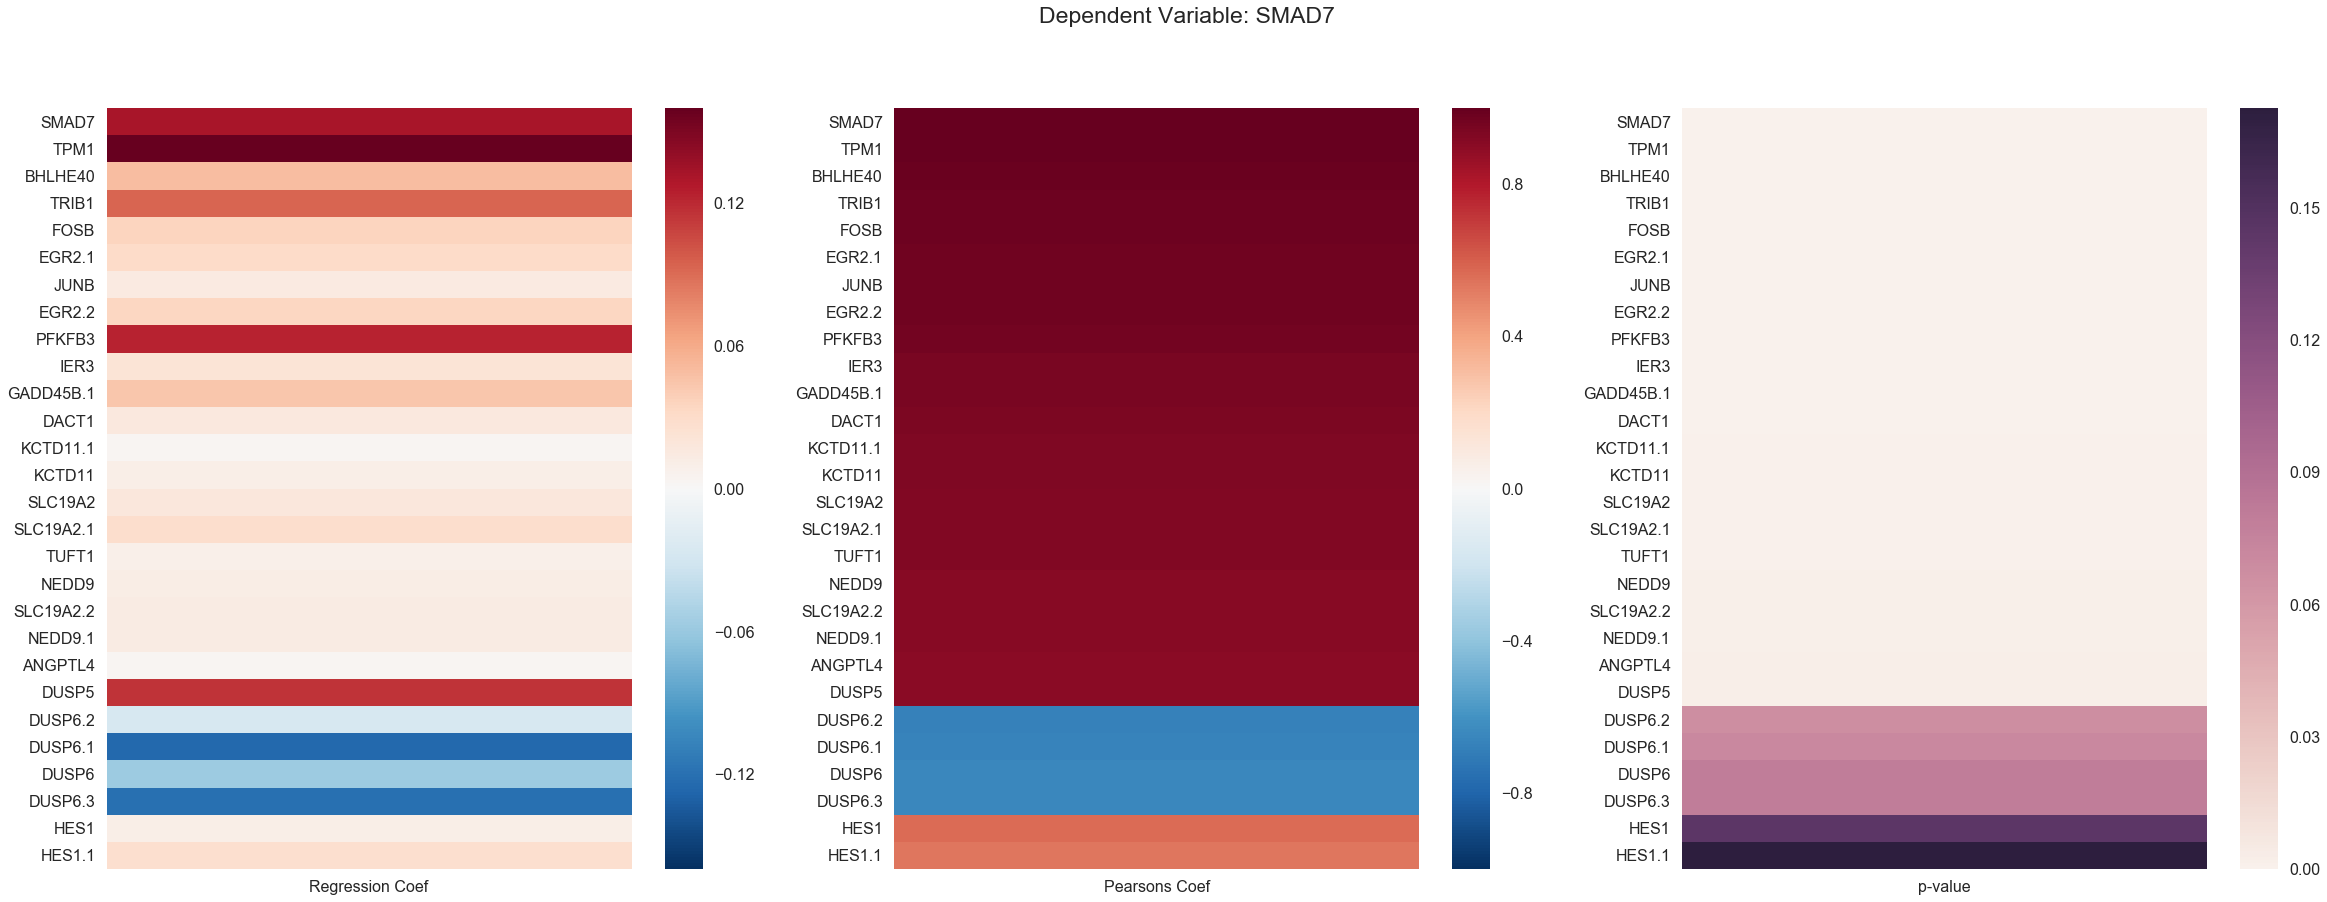

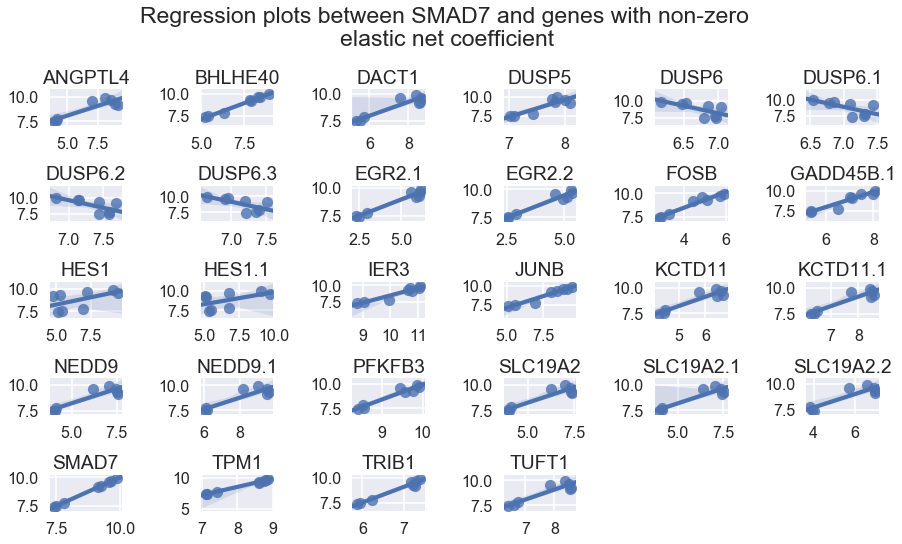

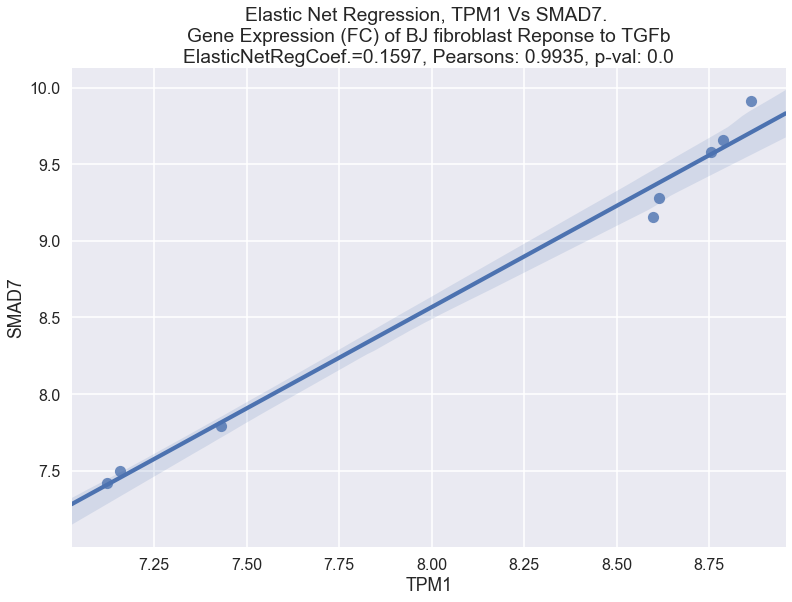

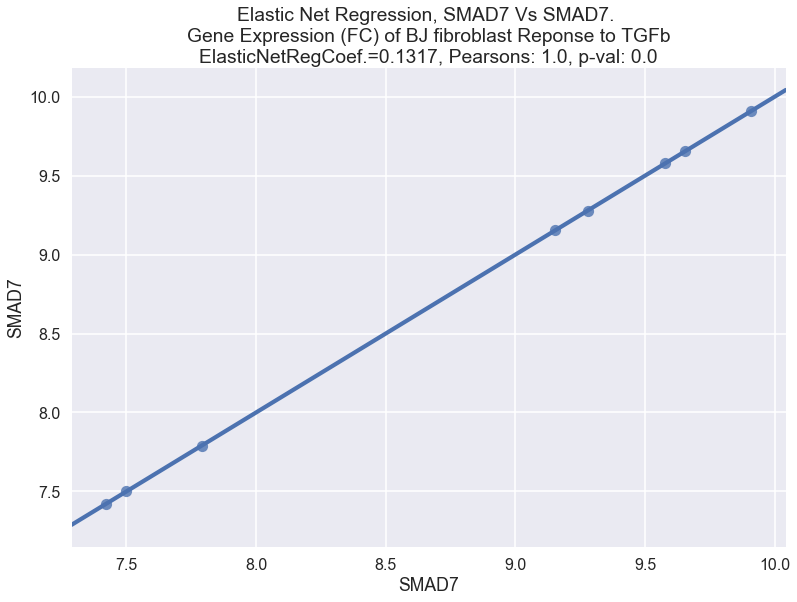

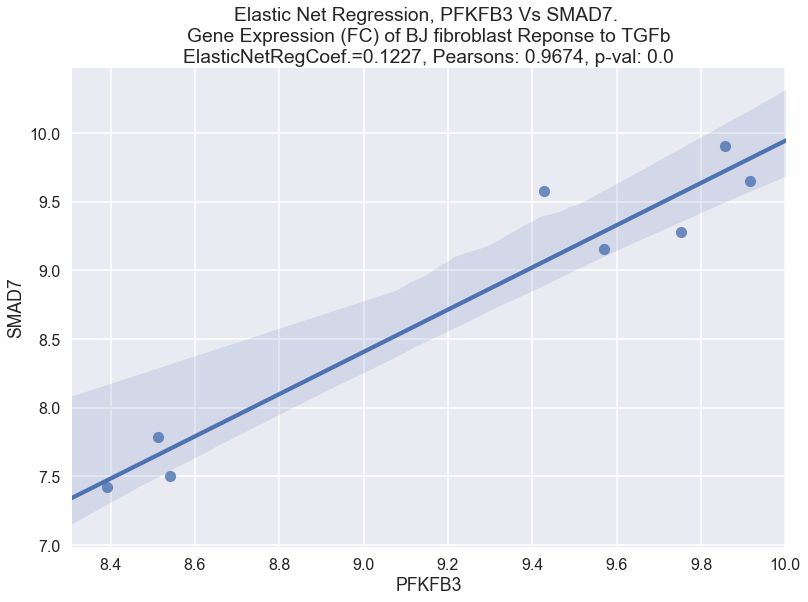

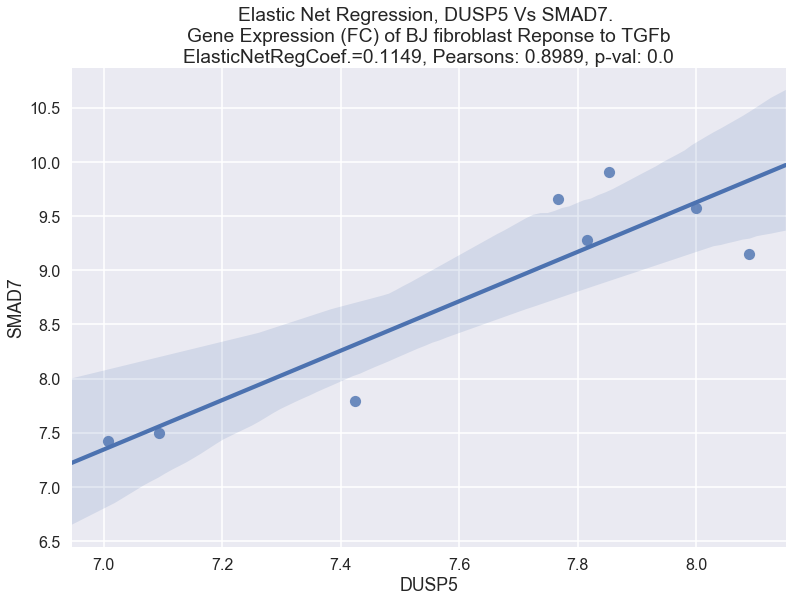

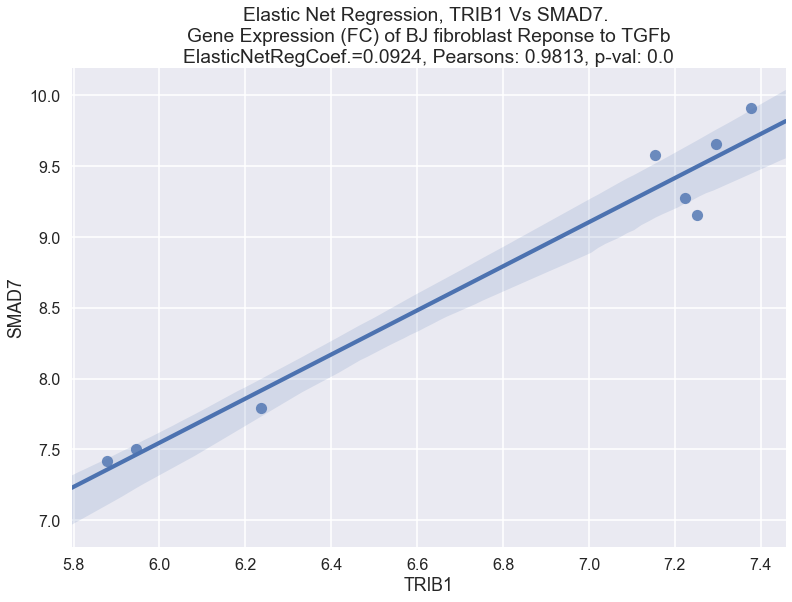

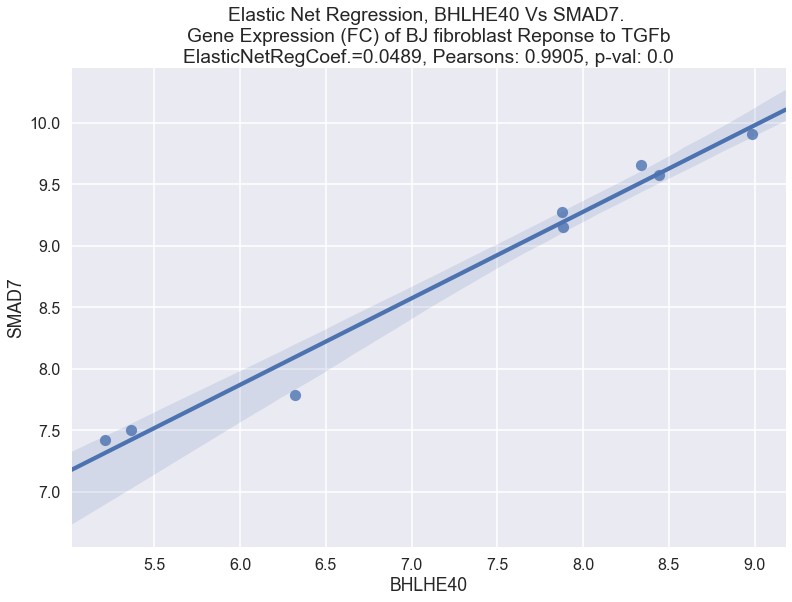

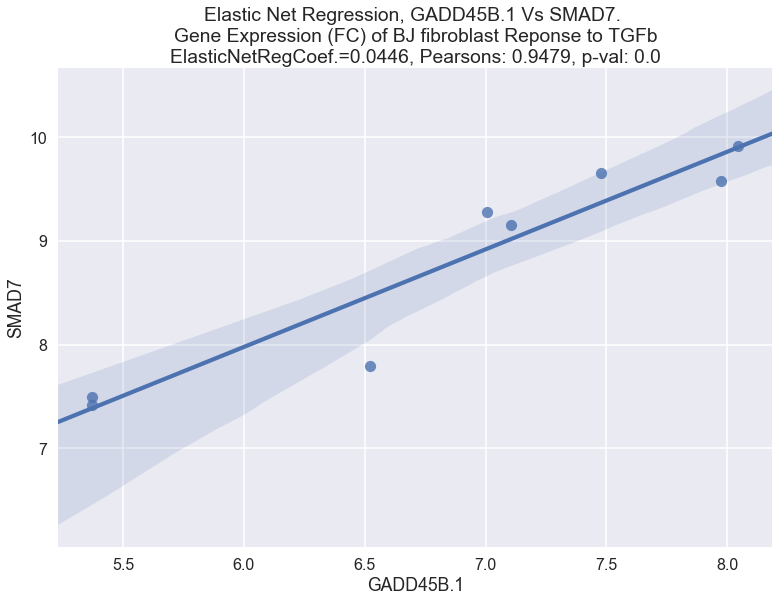

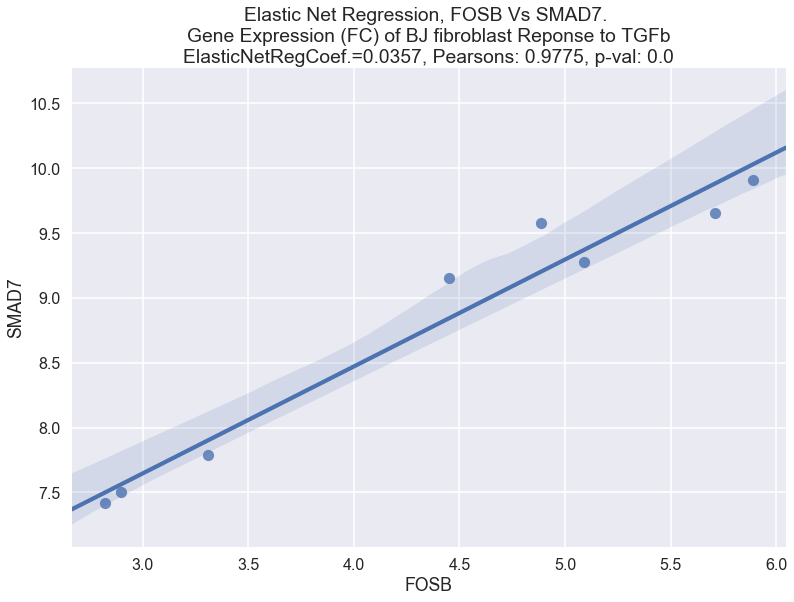

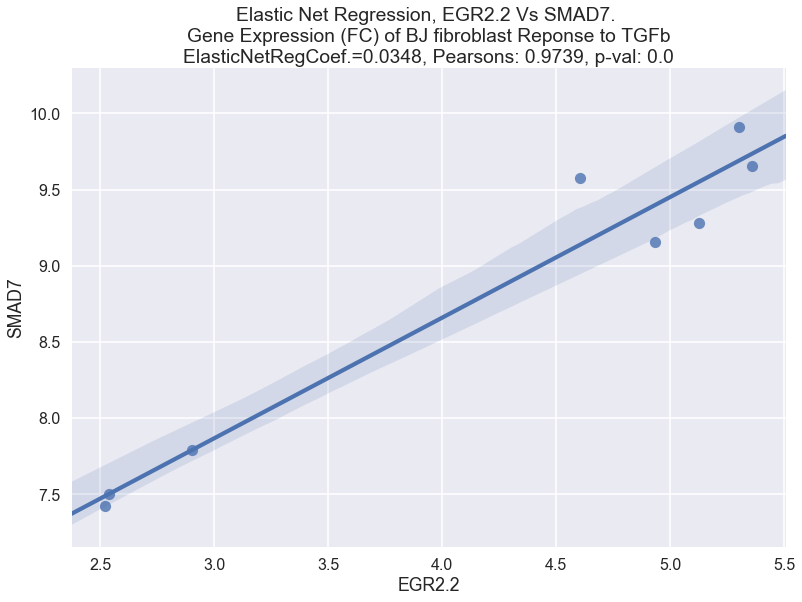

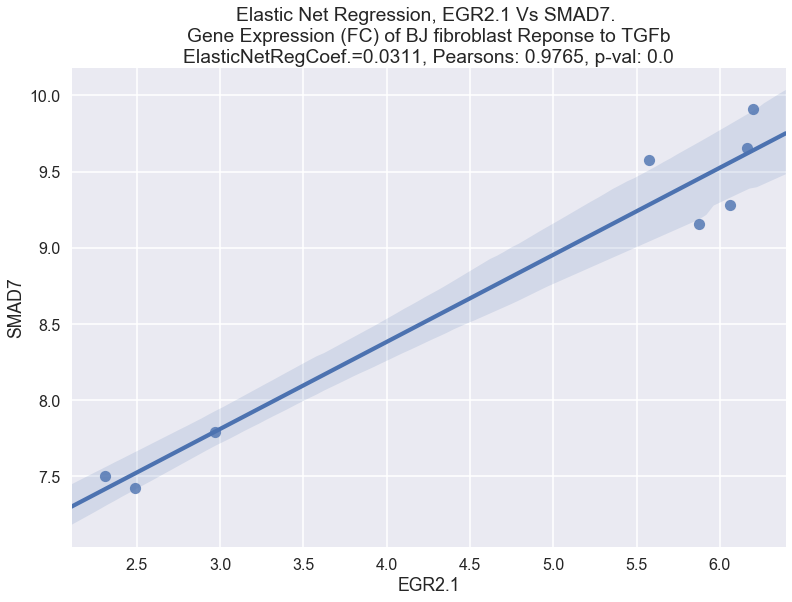

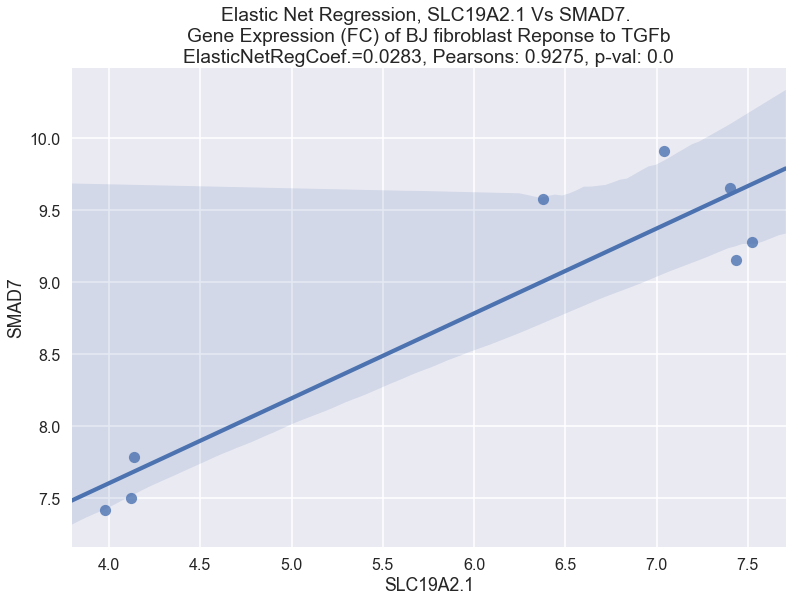

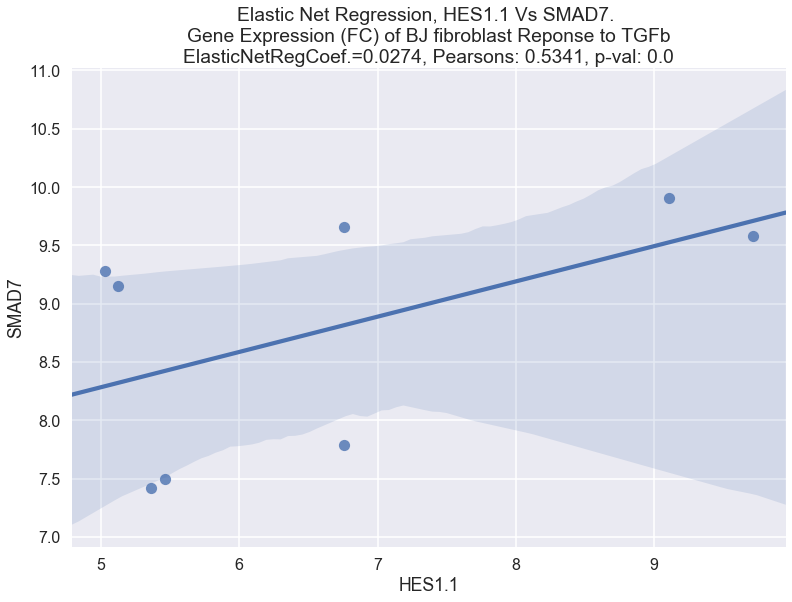

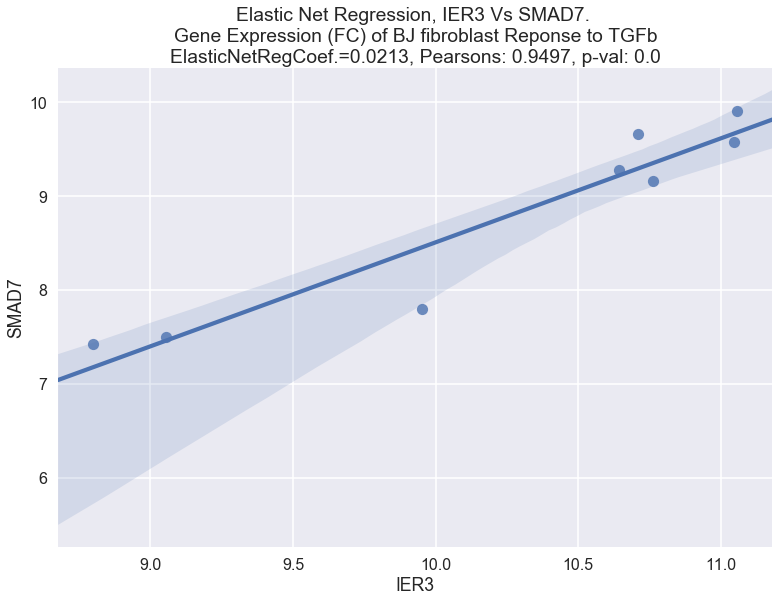

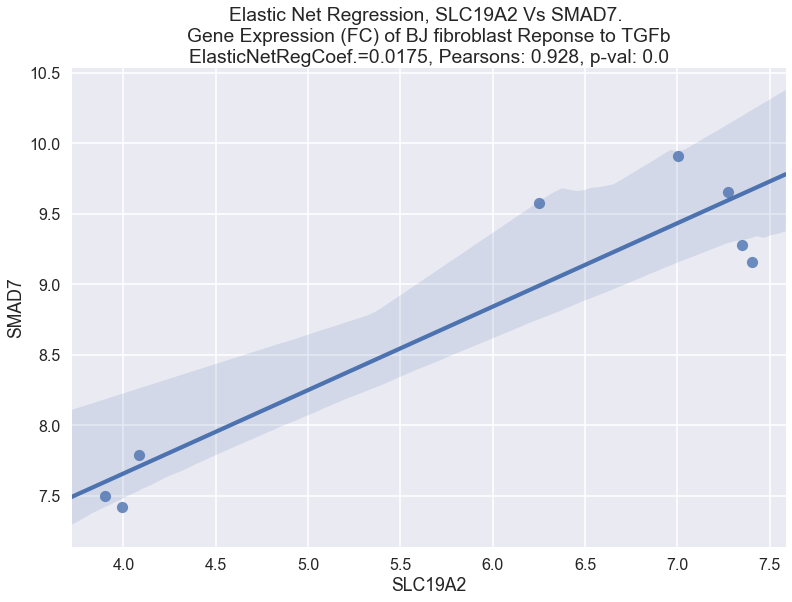

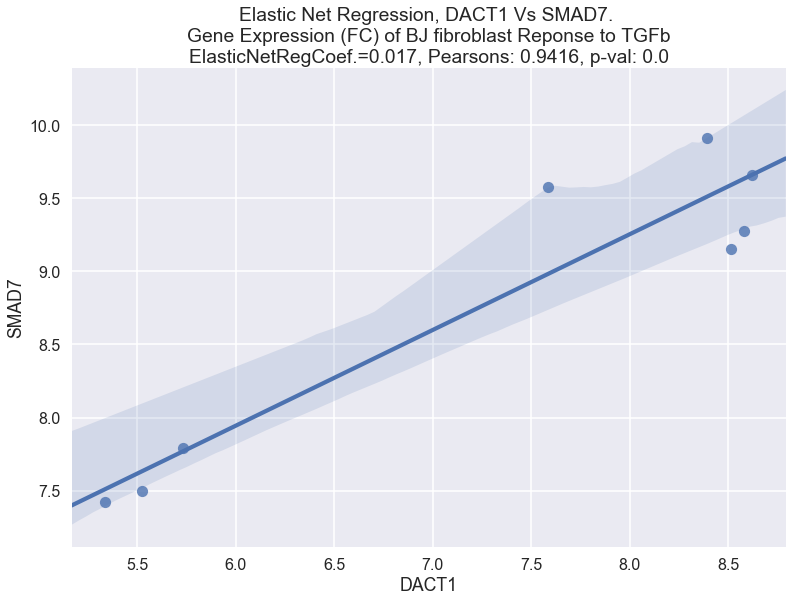

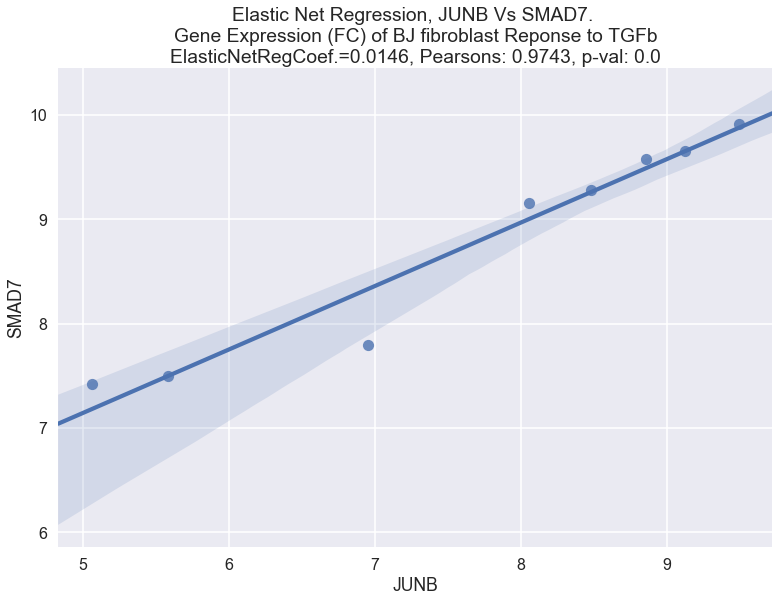

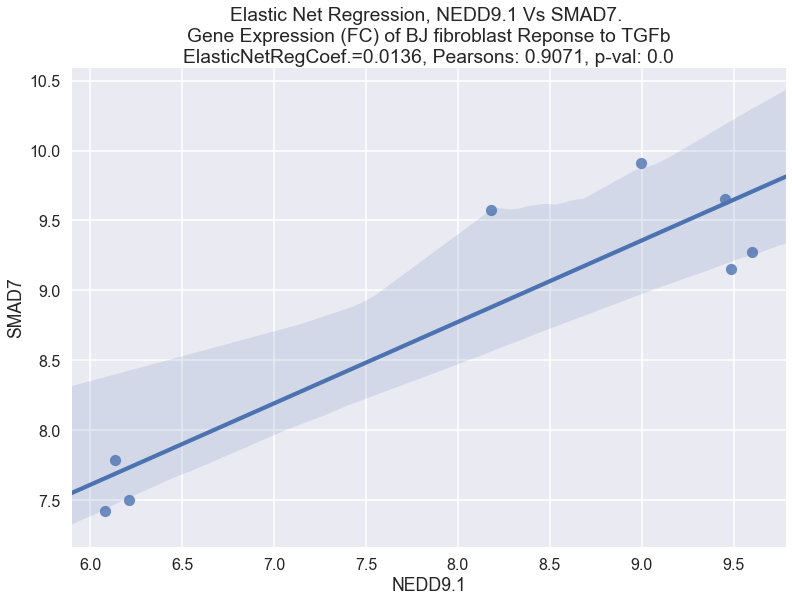

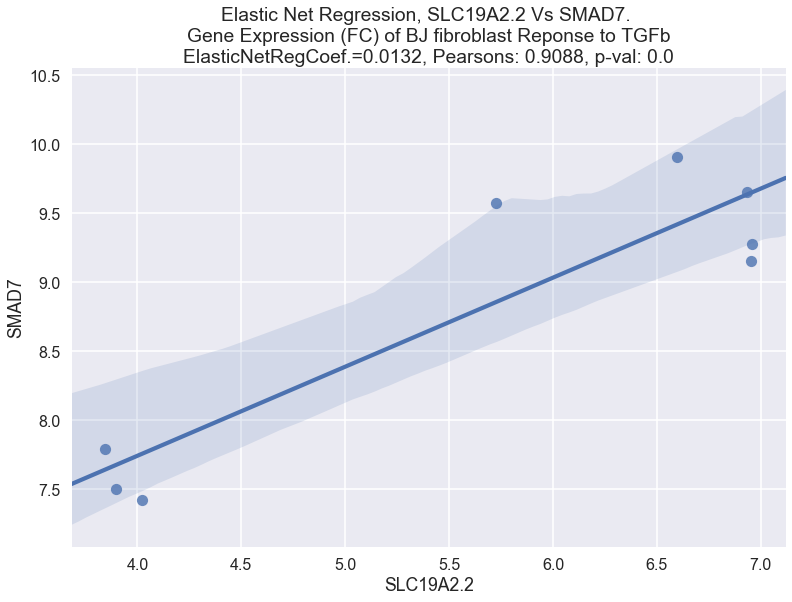

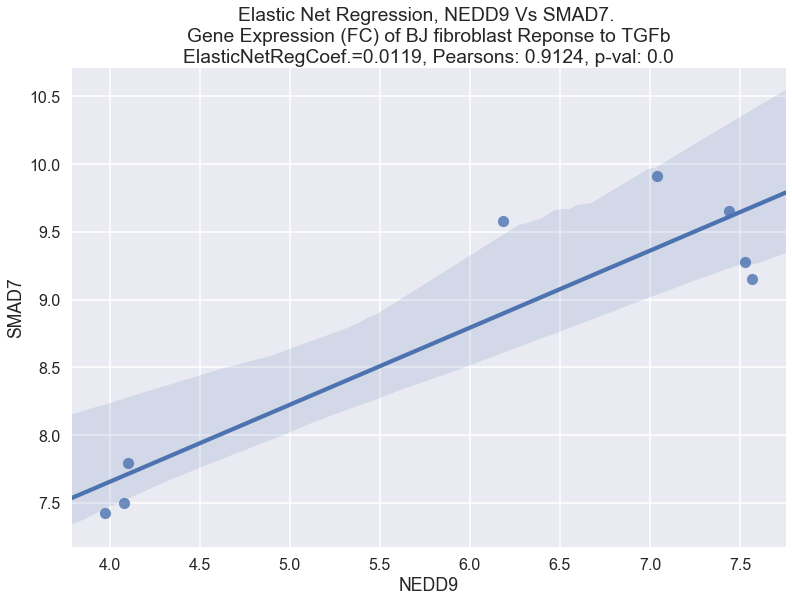

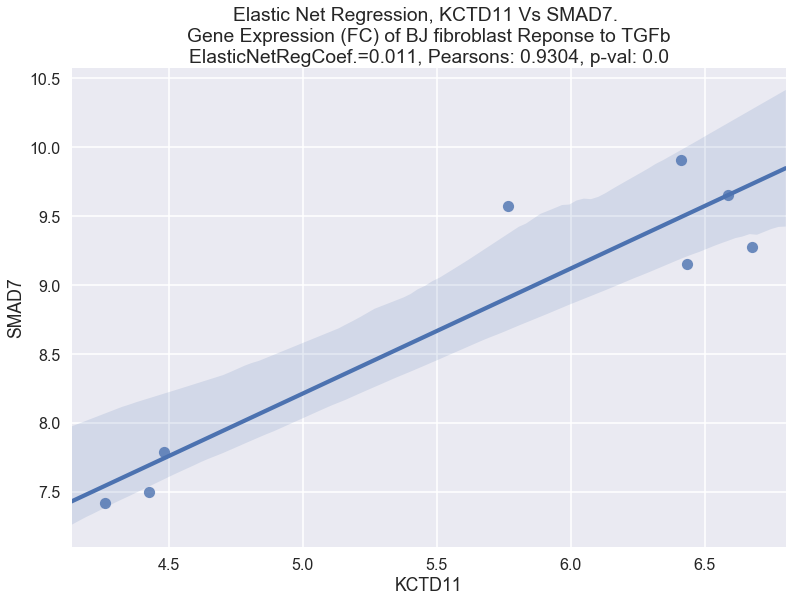

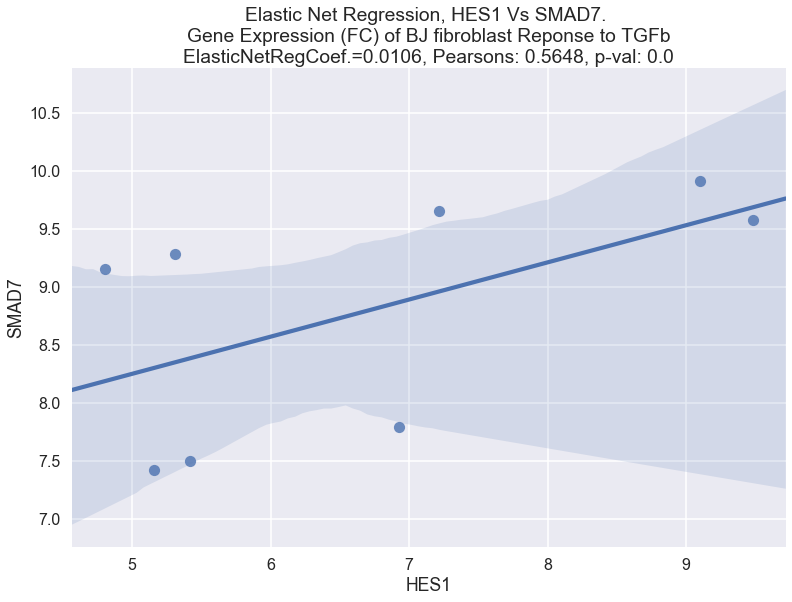

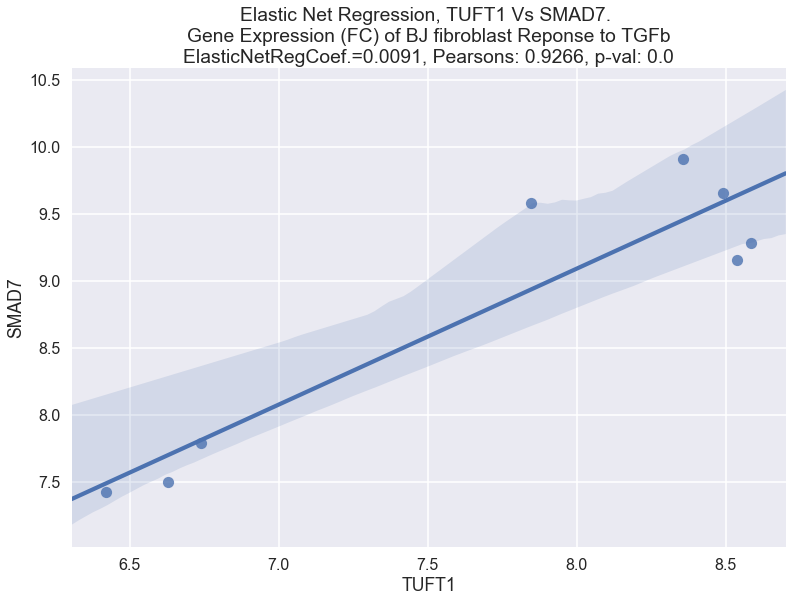

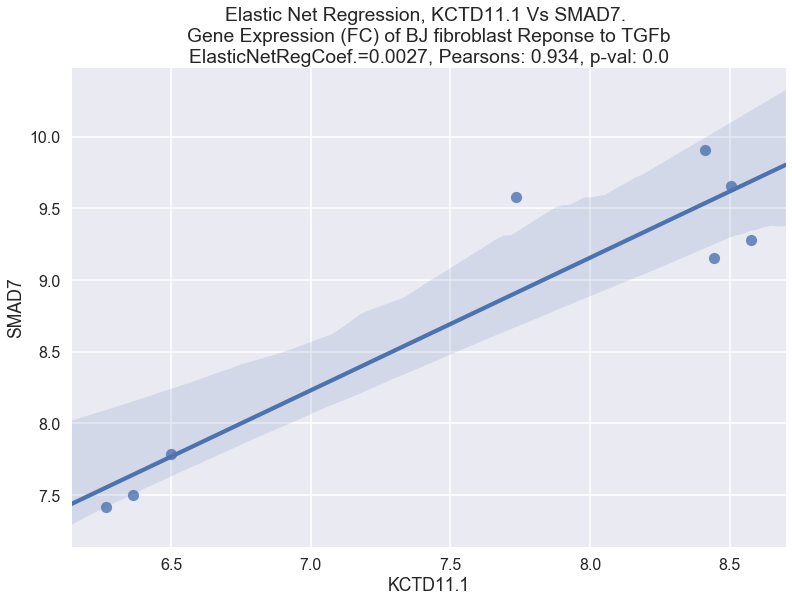

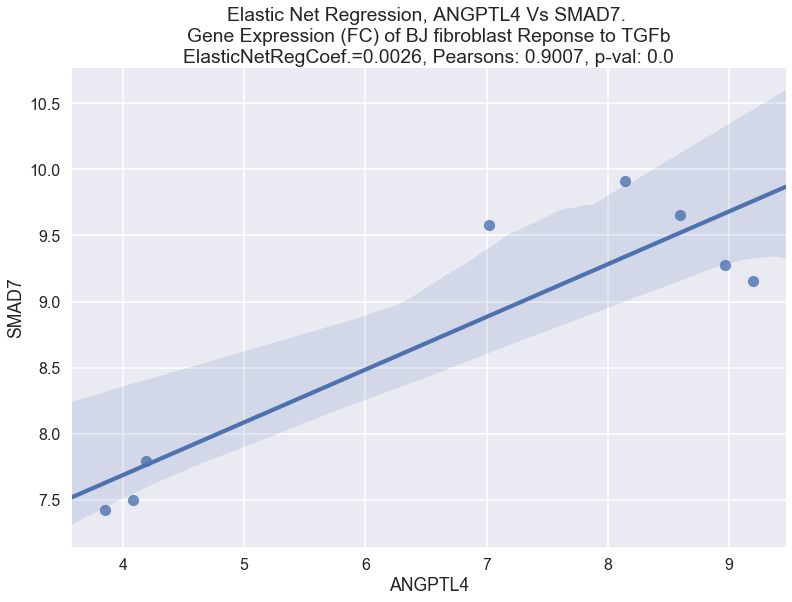

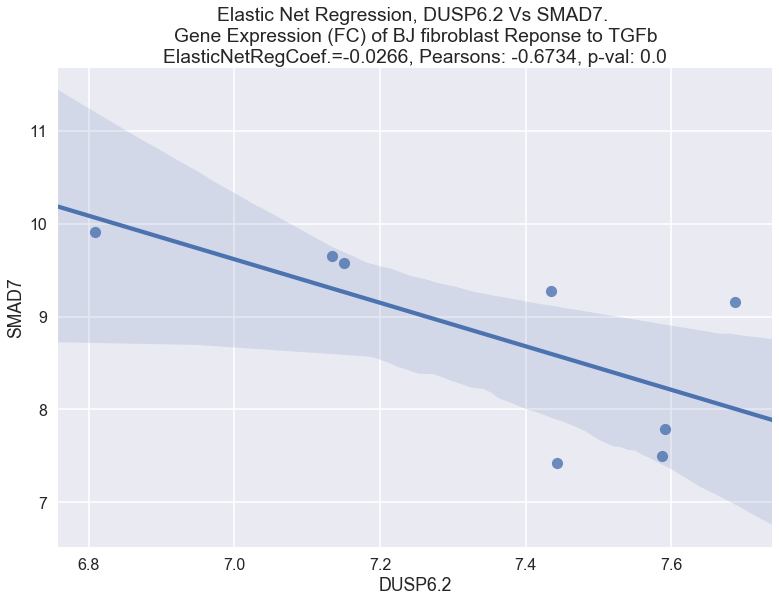

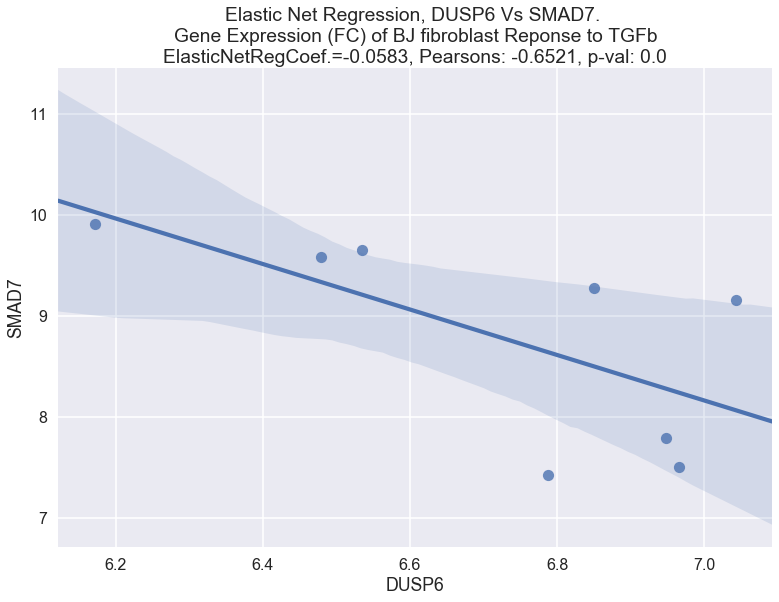

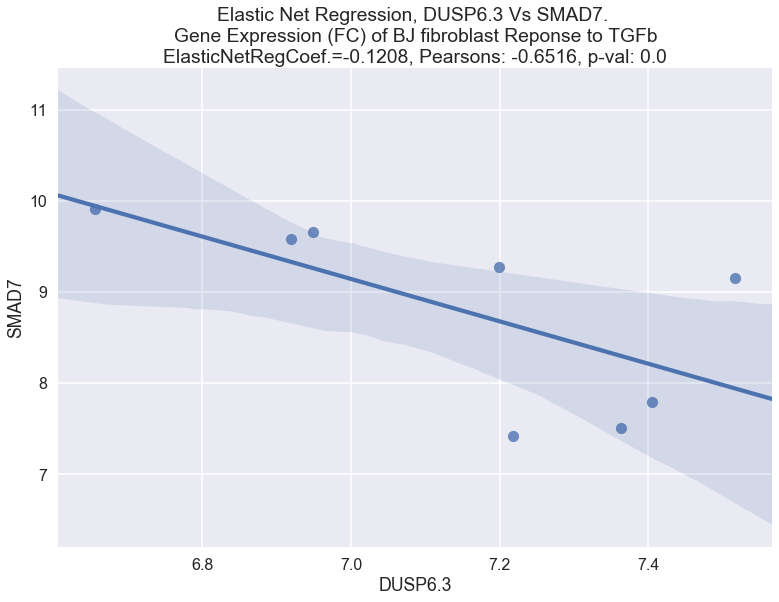

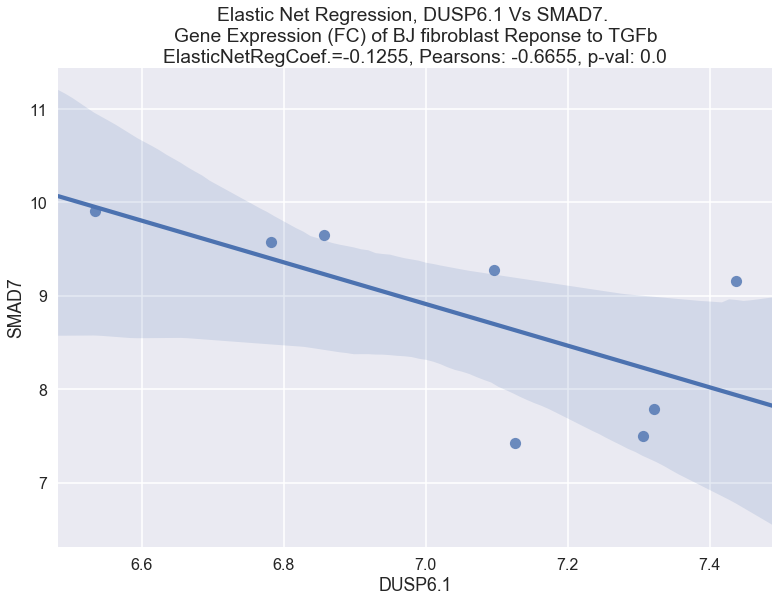

In [7]:
from sklearn import linear_model


def ElasticNetRegression(data,
                         dependent_variable = 'JUNB',
                         max_iter = 1e5,
                         filename = 'RegressionAnalysisGraphs',
                         plot_heatmap=False,
                         plot_regression_square=False,
                         plot_regression_singles=False,
                         save=False):
    """
    args:
        data to perform regression on. Genes are rownames and each row
        corresponds to a single genes expression values. Colnames are irrelevant
        
    kwargs:
        dependent_variable:
            variable which takes on the y (predicted) role
            
        max_iter:
            numeric. Passed on to sklearn.linear_model.<function>
            
        plot_heatmap:
            Boolean. Plot regression coefficients, pearsons coef. and pearsons coef p-value
            as heat maps
            
        plot_regression_square:
            Boolean. Filter data to only include genes which has non-zero coefficient, 
            determined by sklearn.linearmodel then plot each gene against the dependent variable
            as a square
            
        plot_regression_single:
            Boolean. Same as plot_regression_square but plot one graph per plot. 

        folder:
            name of folder to save graphs to
        
        save:
            boolean. save to file
    """

    
    ## check dep variable is in genes
    genes = list(data.index)
    if dependent_variable not in genes:
        raise Exception('{} not in genes'.format(dependent_variable))
    
    ## Format data for input into regression model
    data = data.transpose()
    y = pandas.DataFrame(data[dependent_variable])
    
    # do regression
    reg = linear_model.MultiTaskElasticNetCV(normalize=True, max_iter=max_iter)
    reg.fit(data, y)
    
    ## get coefficients
    df = pandas.DataFrame(reg.coef_, columns=data.columns, index=['Regression Coef']).transpose()
    
    ## extract non-zero coefficients
    df = df[df['Regression Coef']!=0]
    df = df.sort_values(by='Regression Coef', ascending=False)
    
    ## calculate pearsons correlation coef
    genes = list(df.index)
    r=[]
    for gene in genes:
        coef = stats.pearsonr(data[gene],data[dependent_variable])
        r.append(coef)
    r_df = pandas.DataFrame(r, index=genes, columns = ['Pearsons Coef', 'p-value'])
    
    ## merge pearsons correlation and p_value with regression coefficients 
    df=df.sort_index()
    r_df=r_df.sort_index()    
    heat_map_df = pandas.merge(df, r_df, left_index=True, right_index=True)
    
    ## calculate mutual information as well
    
    ## collect figures for plotting later
    figs=[]
    heat_map_df = heat_map_df.sort_values(by='p-value')
    seaborn.set_context(context='poster', font_scale=1)
    if plot_heatmap:
        LOG.info('\tplotting heatmap for {}'.format(dependent_variable))
        fig=plt.figure(figsize=(40,0.5*heat_map_df.shape[0]))
        for i in range(heat_map_df.shape[1]):
            plt.subplot(1,3,i+1)
            seaborn.heatmap( pandas.DataFrame(heat_map_df[heat_map_df.columns[i]]))
            plt.suptitle('Dependent Variable: {}'.format(dependent_variable) )
        figs.append(fig)

            #         if save:
#             pdf.savefig(bbox_inches='tight', dpi=300)


    ## plot regressions as square
    num_non_zero_genes=len(list(df.index))
    num_non_zero_root = numpy.ceil(numpy.sqrt(num_non_zero_genes))
    if plot_regression_square:
        data.index.name='time'
        data=data.reset_index()
        fig=plt.figure()
        for i in range(len(list(df.index))):
            gene = list(df.index)[i]
            LOG.info('\tplotting regplot (square) for {}'.format(gene))
            
            plt.subplot(num_non_zero_root,num_non_zero_root,i+1)
            seaborn.regplot(x=data[gene], y=data[dependent_variable], data=data )
            plt.ylabel('')
            plt.xlabel('')
            plt.title(gene)
            plt.suptitle('Regression plots between {} and genes with non-zero \nelastic net coefficient'.format(dependent_variable))
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        figs.append(fig)
#         if save:
#             pdf.savefig(bbox_inches='tight', dpi=300)


    ## plot regression as single
    if plot_regression_singles:
        data.index.name='time'
        for gene in genes:
            LOG.info('\tPlotting regplot (single) for {}'.format(gene))
            plt.figure()
#             seaborn.lmplot(x=gene, y=dependent_variable, data=data)
            seaborn.regplot(x=data[gene], y=data[dependent_variable], data=data)
            plt.title('Elastic Net Regression, {} Vs {}. \n\
Gene Expression (FC) of BJ fibroblast Reponse to TGFb\n\
ElasticNetRegCoef.={}, Pearsons: {}, p-val: {}'.format(
                gene, dependent_variable,
                round(heat_map_df['Regression Coef'][gene], 4),
                round(heat_map_df['Pearsons Coef'][gene], 4),
                round(heat_map_df['p-value'][gene])))
#         if save:
#             pdf.savefig(bbox_inches='tight', dpi=300)
    return figs, df, heat_map_df


figs = ElasticNetRegression(summary, 'SMAD7', plot_heatmap=True, plot_regression_square=True,
                         plot_regression_singles=True)

In [40]:
##copy frame and relabel columns to include all repeats individually in the regression
data_with_repeats = data.copy()

## informative labels which can be used by scatters
data_with_repeats.columns = list(set(data.columns.get_level_values(1)))*max(data.columns.get_level_values(0))


def run_all():
    SAVE=True
    with PdfPages(os.path.join(os.getcwd(), 'RegressionAnalysisOutput.pdf')) as pdf:
        for gene in sorted(genes):
            LOG.info('Calculating ElasticNet regression for {} as dependent variable'.format(gene))
            figs = ElasticNetRegression(summary, gene, plot_heatmap=True, plot_regression_square=False,
                         plot_regression_singles=False)
            if SAVE:
                [pdf.savefig(fig, bbox_inches='tight', dpi=300) for fig in figs[0]]

2017-07-09 01:20:28,512 - root - INFO - Calculating ElasticNet regression for ABHD17C as dependent variable
2017-07-09 01:20:31,615 - root - INFO - 	plotting heatmap for ABHD17C
2017-07-09 01:20:32,578 - root - INFO - Calculating ElasticNet regression for ADAM19 as dependent variable
2017-07-09 01:20:52,265 - root - INFO - 	plotting heatmap for ADAM19
2017-07-09 01:20:57,085 - root - INFO - Calculating ElasticNet regression for ADAMTS1 as dependent variable
2017-07-09 01:21:26,900 - root - INFO - 	plotting heatmap for ADAMTS1
2017-07-09 01:21:33,173 - root - INFO - Calculating ElasticNet regression for ADAMTS1.1 as dependent variable
2017-07-09 01:22:02,680 - root - INFO - 	plotting heatmap for ADAMTS1.1
2017-07-09 01:22:09,760 - root - INFO - Calculating ElasticNet regression for ADM as dependent variable
2017-07-09 01:22:25,624 - root - INFO - 	plotting heatmap for ADM
2017-07-09 01:22:30,897 - root - INFO - Calculating ElasticNet regression for ADM.1 as dependent variable
2017-07-09

limit_output extension: Maximum message size of 10000 exceeded with 10016 characters